# Import Dependencies

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
import scipy
import rasterio as rio

In [2]:
from tqdm.auto import tqdm
tqdm.pandas()
import os, sys, itertools, gc, functools
from pathlib import Path

In [3]:
import json
import joblib
import PIL
import PIL.ImageDraw
from einops import rearrange

In [4]:
import torch
from transformers import AutoImageProcessor, AutoModel
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Setup Constants

In [5]:
band_filenames = [
    'result.tif',
    'result_Red.tif',
    'result_Green.tif',
    'result_Blue.tif',
    'result_NIR.tif',
    'result_RedEdge.tif',
]


bands_dict = {
    'wr': 'Wideband Red',
    'wg': 'Wideband Green',
    'wb': 'Wideband Blue',
    'r': 'Narrowband Red',
    'g': 'Narrowband Green',
    'b': 'Narrowband Blue',
    'nir': 'Near Infrared',
    're': 'Red Edge',
}

band_keys = ['wr', 'wg', 'wb', 'r', 'g', 'b', 'nir', 're']

# Prepare Datasets

In [6]:
casuarina_93 = Path('Data/casuarina-20220418-93deg')
casuarina_183 = Path('Data/casuarina_20220418_183deg')
chestnut_may = Path('Data/chestnut_nature_park_20210510_90deg43m85pct255deg')
chestnut_dec = Path('Data/chestnut_nature_park_20201218')

In [7]:
def load_dataset(ds_path):
    filenames = [ds_path / i for i in band_filenames]
    arrs = [rio.open(i).read() for i in filenames]
    arrs[0] = arrs[0][:3]
    arrs = np.concatenate(arrs)
    return arrs

In [8]:
casuarina_ds = load_dataset(casuarina_93)
casuarina_183ds = load_dataset(casuarina_183)
chestnut_may_ds = load_dataset(chestnut_may)
chestnut_dec_ds = load_dataset(chestnut_dec)

In [9]:
print(casuarina_ds.shape)
print(casuarina_183ds.shape)
print(chestnut_may_ds.shape)
print(chestnut_dec_ds.shape)

(8, 8482, 7762)
(8, 8494, 8410)
(8, 8088, 5392)
(8, 7620, 4876)


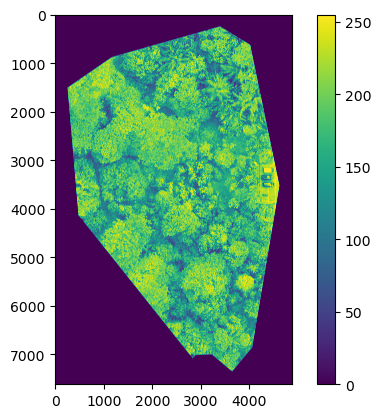

In [10]:
plt.imshow(chestnut_dec_ds[0])
plt.colorbar()
plt.show()

In [11]:
casuarina_93_bounds = pd.read_csv(casuarina_93/'bounds.csv')
casuarina_183_bounds = pd.read_csv(casuarina_183/'bounds.csv')
chestnut_may_bounds = pd.read_csv(chestnut_may/'bounds.csv')
chestnut_dec_bounds = pd.read_csv(chestnut_dec/'bounds.csv')

In [12]:
casuarina_93_bounds['ds'] = 'casuarina'
casuarina_93_bounds['capture'] = '93deg'
casuarina_183_bounds['ds'] = 'casuarina'
casuarina_183_bounds['capture'] = '183deg'
chestnut_may_bounds['ds'] = 'chestnut'
chestnut_may_bounds['capture'] = 'may'
chestnut_dec_bounds['ds'] = 'chestnut'
chestnut_dec_bounds['capture'] = 'dec'

In [13]:
len(casuarina_93_bounds), len(casuarina_183_bounds), len(chestnut_may_bounds), len(chestnut_dec_bounds)

(8, 8, 34, 33)

In [14]:
casuarina_new_bounds = pd.read_csv('new_bounds.csv')
casuarina_new_bounds = casuarina_new_bounds[casuarina_new_bounds['img'].apply(lambda x: 'casuarina' in x)]
casuarina_93deg_new_bounds = casuarina_new_bounds[casuarina_new_bounds['img'].apply(lambda x: '93' in x)]
casuarina_183deg_new_bounds = casuarina_new_bounds[casuarina_new_bounds['img'].apply(lambda x: '183' in x)]

In [15]:
[len(json.loads(casuarina_93deg_new_bounds.iloc[i]['label'])) for i in range(len(casuarina_93deg_new_bounds))]

[118, 118]

In [16]:
[len(json.loads(casuarina_183deg_new_bounds.iloc[i]['label'])) for i in range(len(casuarina_183deg_new_bounds))]

[108, 108, 108, 83]

In [17]:
casuarina_93deg_new_bounds = pd.concat([pd.DataFrame(json.loads(casuarina_93deg_new_bounds.iloc[i]['label'])) for i in [0]])
casuarina_183deg_new_bounds = pd.concat([pd.DataFrame(json.loads(casuarina_183deg_new_bounds.iloc[i]['label'])) for i in [0]])

In [18]:
for df in [casuarina_93deg_new_bounds, casuarina_183deg_new_bounds]:
    df['name'] = df['polygonlabels'].apply(lambda x: x[0])
    df['x0'] = df['points'].apply(lambda i: min([x for x, y in i])) / 100 * df.iloc[0]['original_width']
    df['x1'] = df['points'].apply(lambda i: max([x for x, y in i])) / 100 * df.iloc[0]['original_width']
    df['y0'] = df['points'].apply(lambda i: min([y for x, y in i])) / 100 * df.iloc[0]['original_height']
    df['y1'] = df['points'].apply(lambda i: max([y for x, y in i])) / 100 * df.iloc[0]['original_height']
    df[['x0', 'x1', 'y0', 'y1']] = df[['x0', 'x1', 'y0', 'y1']].astype('int32')
casuarina_93deg_new_bounds['ds'] = 'casuarina'
casuarina_93deg_new_bounds['capture'] = '93deg'
casuarina_183deg_new_bounds['ds'] = 'casuarina'
casuarina_183deg_new_bounds['capture'] = '183deg'

In [19]:
casuarina_93_bounds = casuarina_93deg_new_bounds[casuarina_93_bounds.columns].copy()
casuarina_183_bounds = casuarina_183deg_new_bounds[casuarina_183_bounds.columns].copy()
len(casuarina_93_bounds), len(casuarina_183_bounds),len(chestnut_may_bounds), len(chestnut_dec_bounds)

(118, 108, 34, 33)

In [20]:
def produce_crop(ds, y0, y1, x0, x1):
    return ds[:,y0:y1,x0:x1]

In [21]:
casuarina_93_bounds['crop'] = casuarina_93_bounds[['y0', 'y1', 'x0', 'x1']].apply(lambda x: produce_crop(casuarina_ds, *x), axis=1)
casuarina_183_bounds['crop'] = casuarina_183_bounds[['y0', 'y1', 'x0', 'x1']].apply(lambda x: produce_crop(casuarina_183ds, *x), axis=1)
chestnut_may_bounds['crop'] = chestnut_may_bounds[['y0', 'y1', 'x0', 'x1']].apply(lambda x: produce_crop(chestnut_may_ds, *x), axis=1)
chestnut_dec_bounds['crop'] = chestnut_dec_bounds[['y0', 'y1', 'x0', 'x1']].apply(lambda x: produce_crop(chestnut_dec_ds, *x), axis=1)

In [22]:
def sample_crops(dataset, bounds):
    test_ds = []
    
    for _, row in bounds.iterrows(): 
        label = row['name']  # Assign label
        
        # Extract bounding box coordinates
        x0, x1 = row['x0'], row['x1']
        y0, y1 = row['y0'], row['y1']
        
        # Extract the crop region from dataset
        crop = dataset[:, y0:y1, x0:x1]  
        
        # Check if the crop contains only blank pixels (all zero)
        blank_mask = np.all(crop == 0, axis=0)  # Check per pixel (y, x)
        if np.all(blank_mask):  # Skip completely blank crops
            continue
        
        test_ds.append((crop, label)) 

    return test_ds  

In [23]:
casuarina_test = sample_crops(casuarina_ds, casuarina_93_bounds)
print(len(casuarina_test))
casuarina_183test = sample_crops(casuarina_183ds, casuarina_183_bounds)
print(len(casuarina_183test))
chestnut_may_test = sample_crops(chestnut_may_ds, chestnut_may_bounds)
print(len(chestnut_may_test))
chestnut_dec_test = sample_crops(chestnut_dec_ds, chestnut_dec_bounds)
print(len(chestnut_dec_test))

118
108
34
33


In [24]:
casuarina_93_bounds['name'].unique()

array(['Macaranga Gigantea', 'Palm Tree', 'Campnosperma Auriculatum',
       '_Unknown', 'Prunus polystachya', 'Ixonanthes reticulata',
       'Fagraea fragans', 'Koompassia malaccensis', 'Litsea firma',
       'Shorea Leprosula', 'Alstonia Angulstiloba', 'Syzygium grande'],
      dtype=object)

In [25]:
casuarina_183_bounds['name'].unique()

array(['Macaranga Gigantea', 'Palm Tree', '_Unknown',
       'Prunus polystachya', 'Shorea Leprosula', 'Syzygium grande',
       'Fagraea fragans', 'Campnosperma Auriculatum', 'Litsea firma',
       'Koompassia malaccensis', 'Ixonanthes reticulata',
       'Alstonia Angulstiloba'], dtype=object)

In [26]:
#bounds_df = pd.concat((casuarina_93_bounds, casuarina_183_bounds, chestnut_may_bounds, chestnut_dec_bounds))

In [27]:
chestnut_dec_bounds['name'].unique()

array(['Falcataria Moluccana', 'Ficus Variegata', 'Bridelia Sp.',
       'Spathodea Campanulatum', 'Terminalia Catappa', 'Shorea Leprosula',
       'Syzygium Polyanthum', 'Cinnamomum Iners', 'Clausena Excavata',
       'Alstonia Angulstiloba', 'Sandoricum Koetjape',
       'Sterculia Parviflora', 'Claoxylon Indicum', 'Pometia Pinnata',
       'Calophyllum', 'Pennisetum Purpureum', 'Campnosperma Auriculatum',
       'Leea Indica', 'Dillenia Suffruticosa'], dtype=object)

In [28]:
chestnut_may_bounds['name'].unique()

array(['Falcataria Moluccana', 'Ficus Variegata', 'Bridelia Sp.',
       'Spathodea Campanulatum', 'Terminalia Catappa', 'Shorea Leprosula',
       'Syzygium Polyanthum', 'Cinnamomum Iners', 'Clausena Excavata',
       'Cratoxylum Formosum', 'Alstonia Angulstiloba',
       'Sandoricum Koetjape', 'Sterculia Parviflora', 'Claoxylon Indicum',
       'Pometia Pinnata', 'Calophyllum', 'Pennisetum Purpureum',
       'Campnosperma Auriculatum', 'Leea Indica', 'Dillenia Suffruticosa'],
      dtype=object)

In [29]:
def plot_bands(dataset, n):
    crop, label = dataset[n]  

    fig, axes = plt.subplots(2, 4, figsize=(12, 6))  
    fig.suptitle(f"8 Band Images of the Crop -  {label}", fontsize=16)  # Show label

    for i in range(8):  # Iterate over 8 bands
        ax = axes[i // 4, i % 4]  # Determine position in the grid
        ax.imshow(crop[i, :, :], cmap="viridis")  
        ax.set_title(f"Band: {band_keys[i]}")  
        ax.axis("on") 

    plt.tight_layout()
    plt.show()

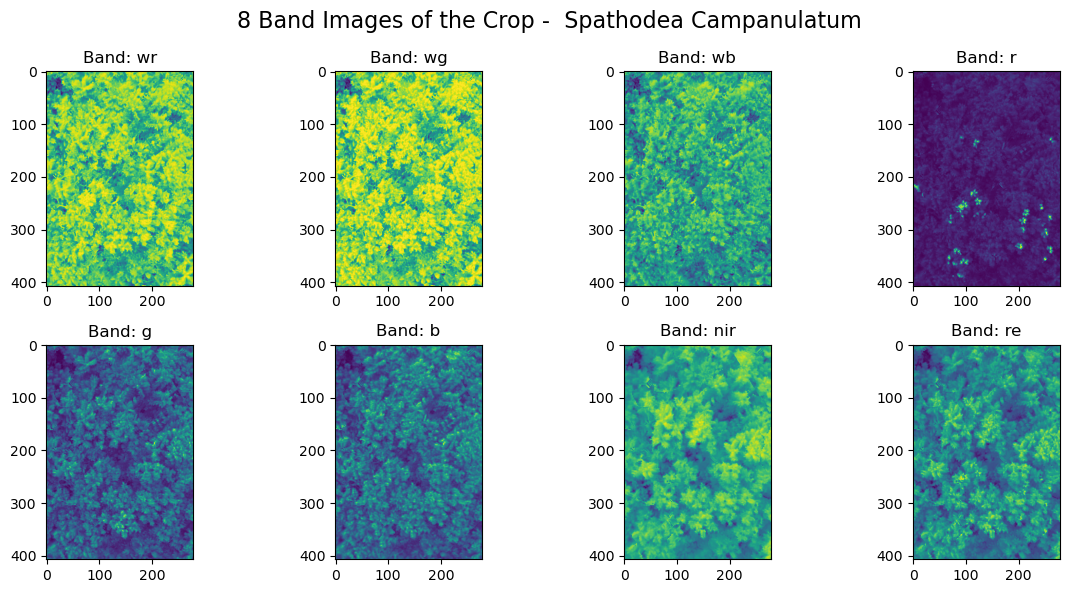

In [30]:
plot_bands(chestnut_dec_test, 32)

### Remove NAN and classes that does not exist in both may and dec

In [31]:
def check_nan_inf_in_dataset(dataset):
    for i, (image, label) in enumerate(dataset):
        if np.any(np.isnan(image)):
            print(f"NaN found in sample {i}, image")
        if np.any(np.isinf(image)):
            print(f"inf found in sample {i}, image")
    print("Check complete.")

check_nan_inf_in_dataset(chestnut_dec_test)

chestnut_dec_test_new = []

for image, label in chestnut_dec_test:
    if not np.any(np.isnan(image)) and not np.any(np.isinf(image)):
        chestnut_dec_test_new.append((image, label))

# Verify
print(f"Original length: {len(chestnut_dec_test)}")
print(f"New length (NaN removed): {len(chestnut_dec_test_new)}")


#Remove'Cratoxylum Formosum' and 'Campnosperma Auriculatum' from chestnut_may_test
chestnut_may_test_new = []

for image, label in chestnut_may_test:
    if not (label == 'Cratoxylum Formosum' or
         label == 'Campnosperma Auriculatum'):
        chestnut_may_test_new.append((image, label))

print()
print("chestnut_may")
print(f"Original length: {len(chestnut_may_test)}")
print(f"New length (NaN removed): {len(chestnut_may_test_new)}")


NaN found in sample 4, image
NaN found in sample 12, image
NaN found in sample 27, image
Check complete.
Original length: 33
New length (NaN removed): 30

chestnut_may
Original length: 34
New length (NaN removed): 32


In [32]:
#Remove unknowns from casuarina
casuarina_test_new = []
casuarina_183test_new = []
unknown_species = []

for image, label in casuarina_test:
    if not (label == '_Unknown'):
        casuarina_test_new.append((image, label))
    else:
        unknown_species.append((image,label))
for image, label in casuarina_183test:
    if not (label == '_Unknown'):
        casuarina_183test_new.append((image, label))
    else:
        unknown_species.append((image, label))
        
print()
print("casuarina_93")
print(f"Original length: {len(casuarina_test)}")
print(f"New length (_Unknown removed): {len(casuarina_test_new)}")

print()
print("casuarina_183")
print(f"Original length: {len(casuarina_183test)}")
print(f"New length (_Unknown removed): {len(casuarina_183test_new)}")

print()
print("unknown_species")
print(f"Length: {len(unknown_species)}")


casuarina_93
Original length: 118
New length (_Unknown removed): 45

casuarina_183
Original length: 108
New length (_Unknown removed): 45

unknown_species
Length: 136


In [33]:
may_classes = set(label for _, label in chestnut_may_test_new)
casuarina_classes = set(label for _, label in casuarina_test_new)

ood_classes = may_classes - casuarina_classes
print("Classes in chestnut but not in casuarina:", sorted(ood_classes))


Classes in chestnut but not in casuarina: ['Bridelia Sp.', 'Calophyllum', 'Cinnamomum Iners', 'Claoxylon Indicum', 'Clausena Excavata', 'Dillenia Suffruticosa', 'Falcataria Moluccana', 'Ficus Variegata', 'Leea Indica', 'Pennisetum Purpureum', 'Pometia Pinnata', 'Sandoricum Koetjape', 'Spathodea Campanulatum', 'Sterculia Parviflora', 'Syzygium Polyanthum', 'Terminalia Catappa']


## LDA Linear Discriminant Analysis

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


  0%|          | 0/45 [00:00<?, ?it/s]

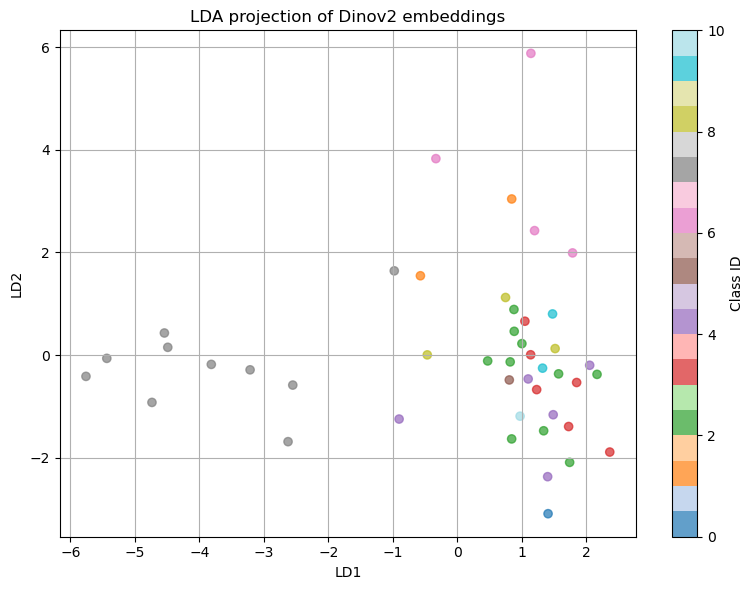

In [34]:
# Load pretrained model and processor
processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
model = AutoModel.from_pretrained('facebook/dinov2-base')
model.eval()

# Normalize individual channel to [0, 255]
def normalize_image(img_slice):
    img_min = img_slice.min()
    img_max = img_slice.max()
    if img_max > img_min:
        return ((img_slice - img_min) / (img_max - img_min) * 255).astype(np.uint8)
    else:
        return np.zeros_like(img_slice, dtype=np.uint8)

# Feature extraction
embeddings = []
labels = []

for img, label in tqdm(casuarina_test_new):
    img_rgb = np.stack([
        normalize_image(img[1]),
        normalize_image(img[6]),
        normalize_image(img[7])
    ], axis=2)  # (H, W, 3), dtype: uint8

    inputs = processor(images=img_rgb, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Use mean pooling over spatial tokens
    feature = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    embeddings.append(feature)
    labels.append(label)

embeddings = np.array(embeddings)
labels = np.array(labels)

# Encode labels to integer
le = LabelEncoder()
label_ids = le.fit_transform(labels)

# Fit
lda = LinearDiscriminantAnalysis()
lda_features = lda.fit_transform(embeddings, label_ids)

# Save LDA model
joblib.dump(lda, "lda_model_casuarina.pkl")
np.save("lda_embeddings_casuarina.npy", lda_features)
np.save("lda_labels_casuarina.npy", label_ids)


plt.figure(figsize=(8, 6))
if lda_features.shape[1] == 1:
    plt.scatter(lda_features[:, 0], np.zeros_like(lda_features[:, 0]), c=label_ids, cmap='tab20', alpha=0.7)
elif lda_features.shape[1] >= 2:
    plt.scatter(lda_features[:, 0], lda_features[:, 1], c=label_ids, cmap='tab20', alpha=0.7)
plt.colorbar(label="Class ID")
plt.title("LDA projection of Dinov2 embeddings")
plt.xlabel("LD1")
plt.ylabel("LD2" if lda_features.shape[1] >= 2 else "")
plt.grid(True)
plt.tight_layout()
plt.savefig("lda_visualization_casuarina.png")
plt.show()


C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Clustering Accuracy: 48.89%


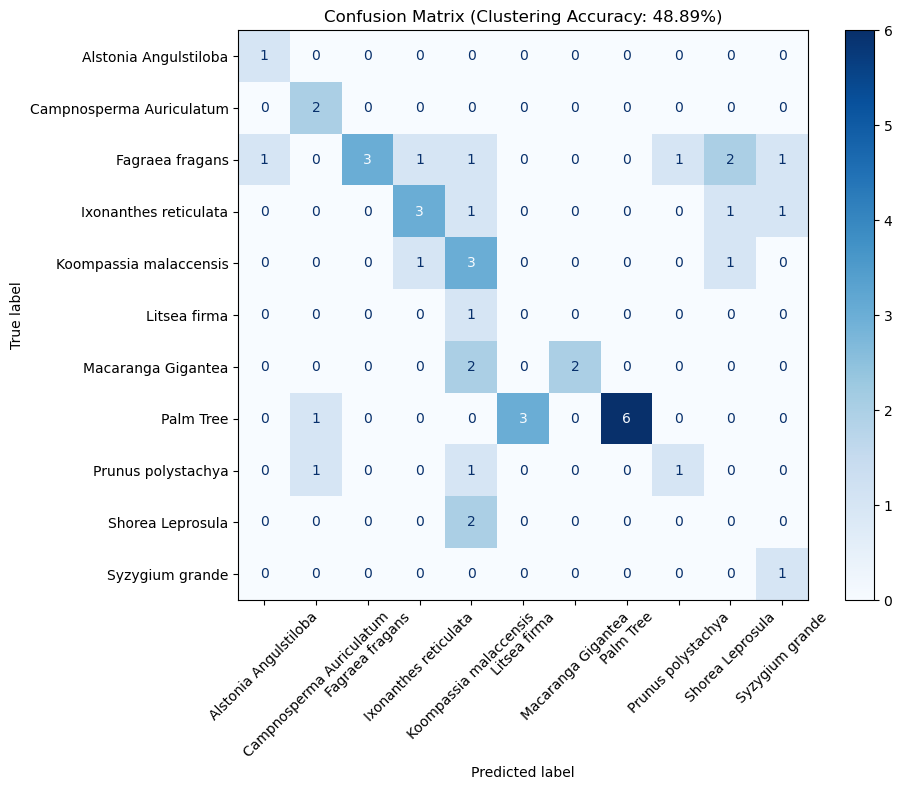

In [35]:
le = LabelEncoder()
label_ids = le.fit_transform(labels)
n_classes = len(np.unique(label_ids))

kmeans = KMeans(n_clusters=n_classes, random_state=42)
pred_labels = kmeans.fit_predict(lda_features)

def best_map(true_labels, pred_labels):
    D = confusion_matrix(true_labels, pred_labels)
    row_ind, col_ind = linear_sum_assignment(-D)
    new_preds = np.zeros_like(pred_labels)
    for i, j in zip(col_ind, row_ind):
        new_preds[pred_labels == i] = j
    return new_preds

matched_preds = best_map(label_ids, pred_labels)
acc = accuracy_score(label_ids, matched_preds)
print(f"Clustering Accuracy: {acc * 100:.2f}%")

cm = confusion_matrix(label_ids, matched_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title(f"Confusion Matrix (Clustering Accuracy: {acc * 100:.2f}%)")
plt.tight_layout()
plt.savefig("confusion_matrix_casuarian.png", dpi=300)
plt.show()

In [36]:
from sklearn.cluster import KMeans

lda = joblib.load("lda_model_casuarina.pkl")

lda_scores_train = lda.transform(embeddings)  
kmeans_model = KMeans(n_clusters=18, random_state=42).fit(lda_scores_train)

C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


### Prepare Embeddings for Chestnut Dec and Casuarina

In [37]:
def prepare_embeddings_and_calculate_energy(dataset):
    embeddings = []
    labels = []

    for img, label in tqdm(dataset):
        img_rgb = np.stack([
            normalize_image(img[1]),
            normalize_image(img[6]),
            normalize_image(img[7])
        ], axis=2)  # (H, W, 3), dtype: uint8

        inputs = processor(images=img_rgb, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)

        # Use mean pooling over spatial tokens
        feature = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        embeddings.append(feature)
        labels.append(label)

    # Convert to arrays
    embeddings = np.array(embeddings)
    
    new_feature = lda.transform(embeddings) 

    lda_scores = lda.transform(embeddings) 
    cluster_distances = kmeans_model.transform(lda_scores)  
    energy = np.log(np.sum(np.exp(-cluster_distances)) / np.sum(np.exp(-cluster_distances), axis=1))

    # Prepare labels (convert to numeric for grouping)
    le = LabelEncoder()
    label_ids = le.fit_transform(labels)
    unique_classes = le.classes_

    # Plot energy distribution
    plt.figure(figsize=(12, 6))
    palette = sns.color_palette("hsv", len(unique_classes))

    for i, class_label in enumerate(unique_classes):
        class_energy = energy[label_ids == i]
        sns.kdeplot(class_energy, label=class_label, color=palette[i], fill=True, alpha=0.3)

    plt.title("Energy Distribution per Class")
    plt.xlabel("Energy (L2 Norm)")
    plt.ylabel("Density")
    plt.legend(title="Class")
    plt.grid(True)
    plt.tight_layout()
    #plt.savefig("energy_distribution_183.png", dpi=300)
    plt.show()
    
    return energy, labels

  0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\Dell\AppData\Local\Temp\ipykernel_32584\2944065062.py:41: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(class_energy, label=class_label, color=palette[i], fill=True, alpha=0.3)
C:\Users\Dell\AppData\Local\Temp\ipykernel_32584\2944065062.py:41: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(class_energy, label=class_label, color=palette[i], fill=True, alpha=0.3)
C:\Users\Dell\AppData\Local\Temp\ipykernel_32584\2944065062.py:41: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(class_energy, label=class_label, color=palette[i], fill=True, alpha=0.3)
C:\Users\Dell\AppData\Local\Temp\ipykernel_32584\2944065062.py:41: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.k

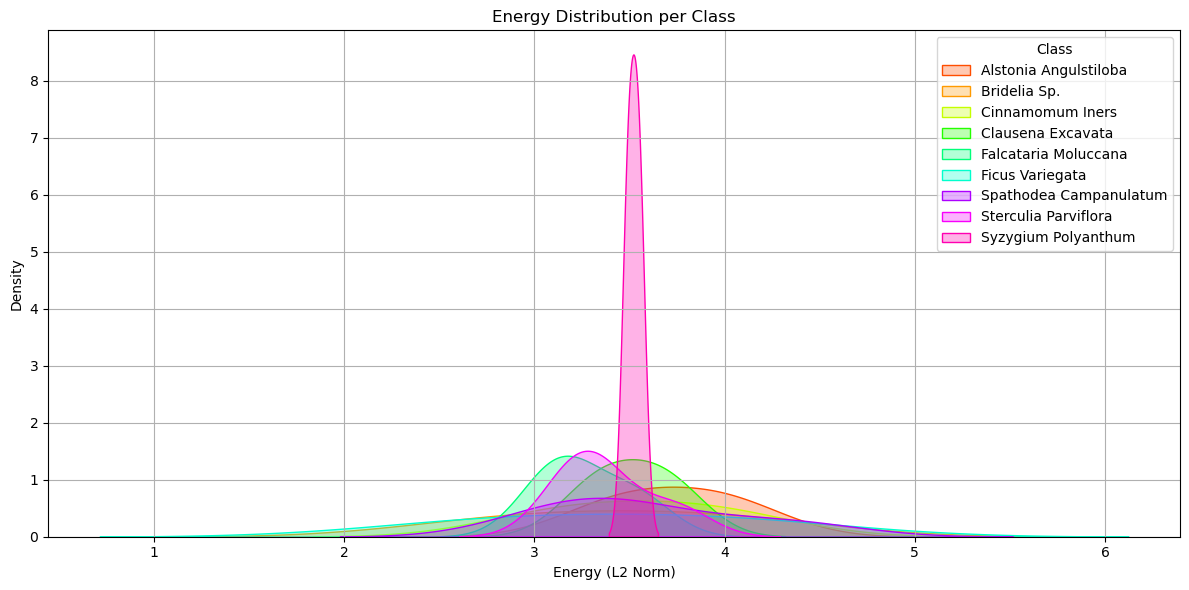

In [38]:
energy_may, labels_may = prepare_embeddings_and_calculate_energy(chestnut_may_test_new)

  0%|          | 0/45 [00:00<?, ?it/s]

C:\Users\Dell\AppData\Local\Temp\ipykernel_32584\2944065062.py:41: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(class_energy, label=class_label, color=palette[i], fill=True, alpha=0.3)
C:\Users\Dell\AppData\Local\Temp\ipykernel_32584\2944065062.py:41: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(class_energy, label=class_label, color=palette[i], fill=True, alpha=0.3)
C:\Users\Dell\AppData\Local\Temp\ipykernel_32584\2944065062.py:41: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(class_energy, label=class_label, color=palette[i], fill=True, alpha=0.3)


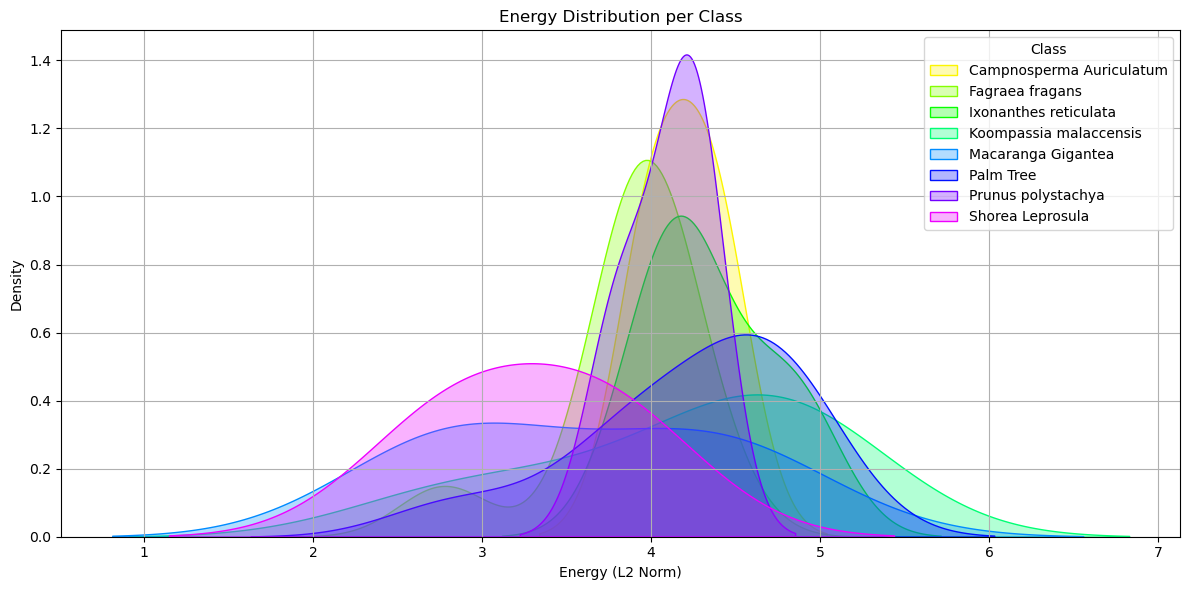

In [39]:
energy, labels = prepare_embeddings_and_calculate_energy(casuarina_test_new)

  0%|          | 0/30 [00:00<?, ?it/s]

C:\Users\Dell\AppData\Local\Temp\ipykernel_32584\2944065062.py:41: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(class_energy, label=class_label, color=palette[i], fill=True, alpha=0.3)
C:\Users\Dell\AppData\Local\Temp\ipykernel_32584\2944065062.py:41: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(class_energy, label=class_label, color=palette[i], fill=True, alpha=0.3)
C:\Users\Dell\AppData\Local\Temp\ipykernel_32584\2944065062.py:41: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(class_energy, label=class_label, color=palette[i], fill=True, alpha=0.3)
C:\Users\Dell\AppData\Local\Temp\ipykernel_32584\2944065062.py:41: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.k

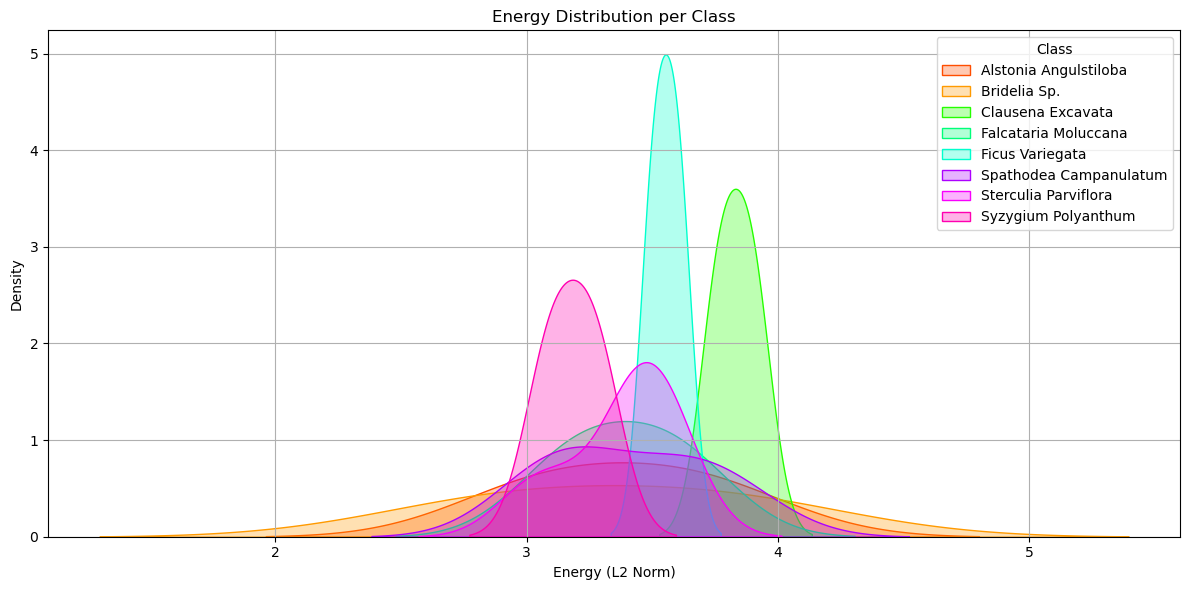

In [40]:
energy_dec, labels_dec = prepare_embeddings_and_calculate_energy(chestnut_dec_test_new)

  0%|          | 0/45 [00:00<?, ?it/s]

C:\Users\Dell\AppData\Local\Temp\ipykernel_32584\2944065062.py:41: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(class_energy, label=class_label, color=palette[i], fill=True, alpha=0.3)
C:\Users\Dell\AppData\Local\Temp\ipykernel_32584\2944065062.py:41: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(class_energy, label=class_label, color=palette[i], fill=True, alpha=0.3)
C:\Users\Dell\AppData\Local\Temp\ipykernel_32584\2944065062.py:41: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(class_energy, label=class_label, color=palette[i], fill=True, alpha=0.3)


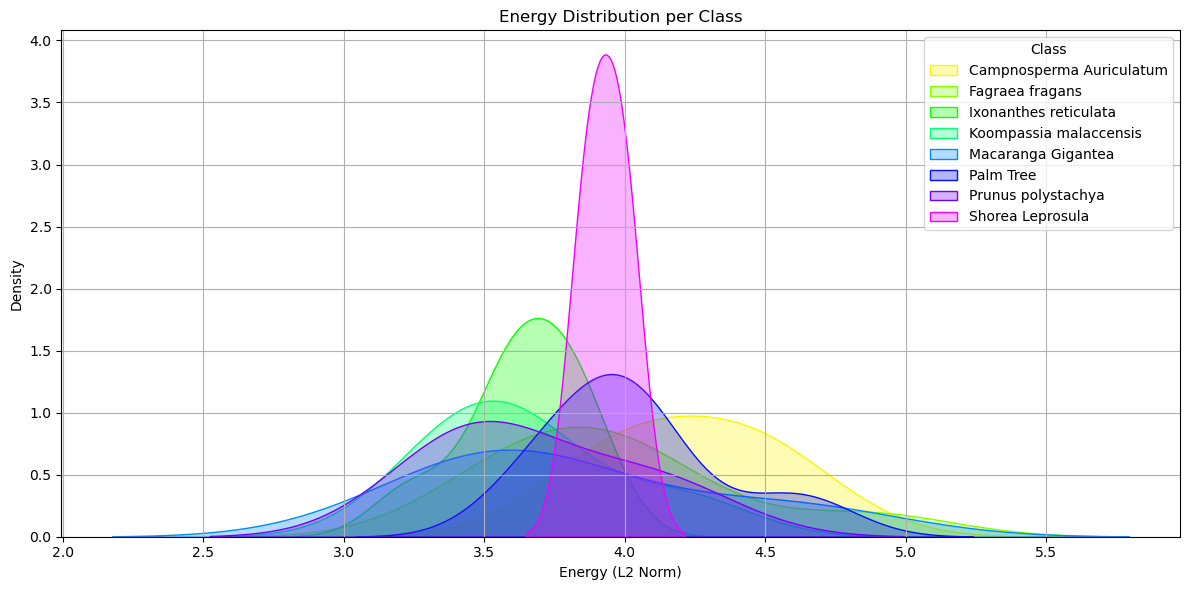

In [41]:
energy_183, labels_183 = prepare_embeddings_and_calculate_energy(casuarina_183test_new)

  0%|          | 0/136 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


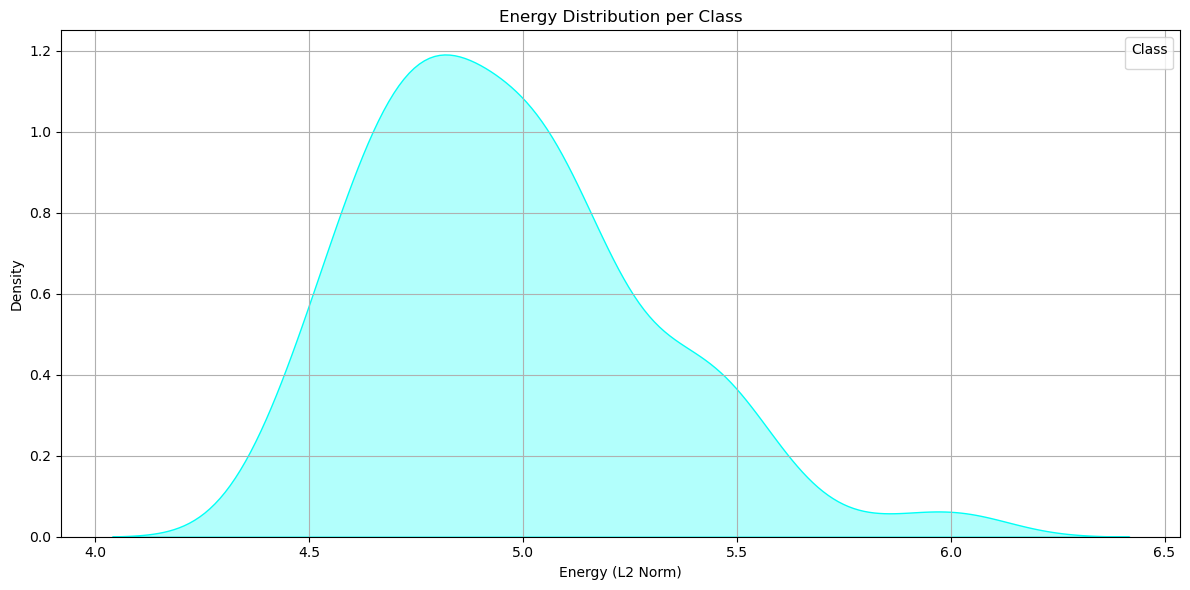

In [42]:
energy_unknown, labels_unknown = prepare_embeddings_and_calculate_energy(unknown_species)

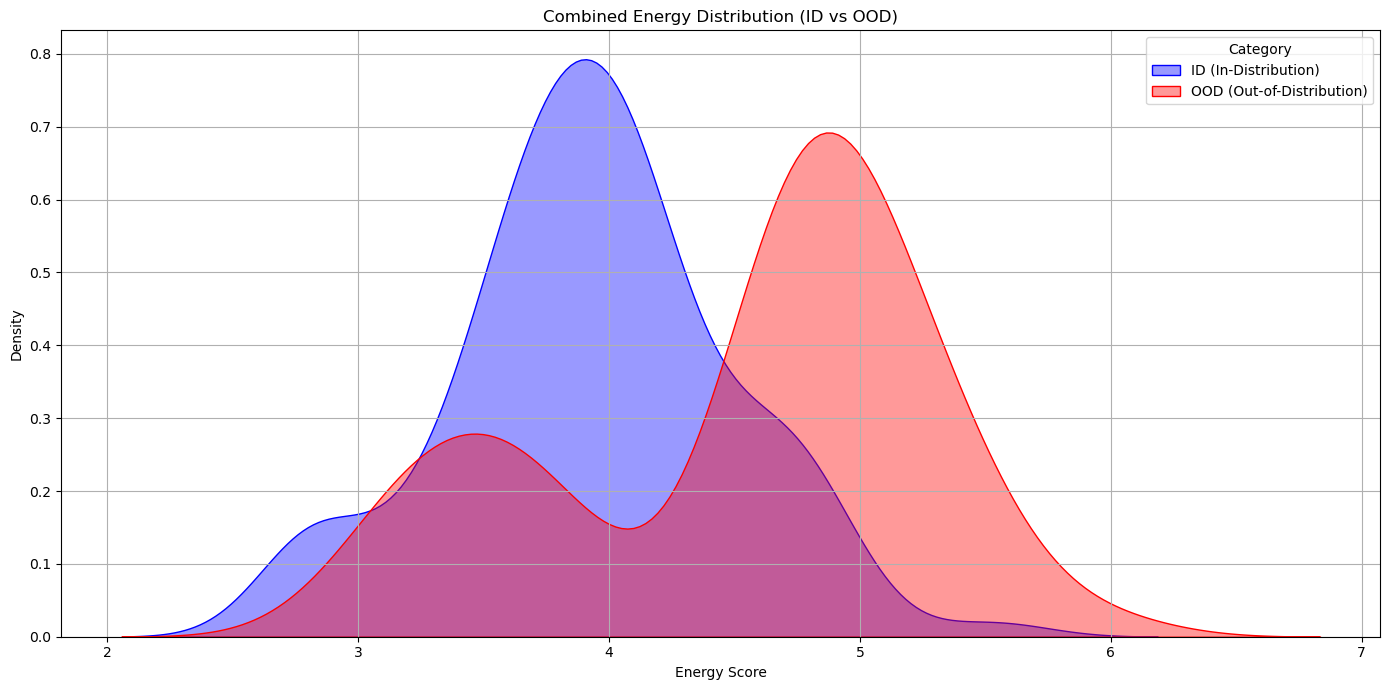

In [43]:
#Based on OOD classes obtained above
ood_classes = {
    'Bridelia Sp.', 'Calophyllum', 'Cinnamomum Iners', 'Claoxylon Indicum', 
    'Clausena Excavata', 'Dillenia Suffruticosa', 'Falcataria Moluccana', 
    'Ficus Variegata', 'Leea Indica', 'Pennisetum Purpureum', 'Pometia Pinnata', 
    'Sandoricum Koetjape', 'Spathodea Campanulatum', 'Sterculia Parviflora', 
    'Syzygium Polyanthum', 'Terminalia Catappa','_Unknown'
}

# Combine energy and labels
all_energy = np.concatenate([energy, energy_may,energy_dec,energy_183, energy_unknown])
all_labels = np.concatenate([labels, labels_may,labels_dec,labels_183, labels_unknown])

# Create binary ID/OOD labels (1=OOD, 0=ID)
is_ood = np.array([label in ood_classes for label in all_labels])

# Plot setup
plt.figure(figsize=(14, 7))
palette = {'ID': 'blue', 'OOD': 'red'}

# Plot KDE for ID vs OOD
sns.kdeplot(
    data=all_energy[~is_ood],
    label='ID (In-Distribution)',
    color=palette['ID'],
    fill=True,
    alpha=0.4
)
sns.kdeplot(
    data=all_energy[is_ood],
    label='OOD (Out-of-Distribution)',
    color=palette['OOD'],
    fill=True,
    alpha=0.4
)

plt.title("Combined Energy Distribution (ID vs OOD)")
plt.xlabel("Energy Score")
plt.ylabel("Density")
plt.legend(title="Category")
plt.grid(True)
plt.tight_layout()
plt.show()


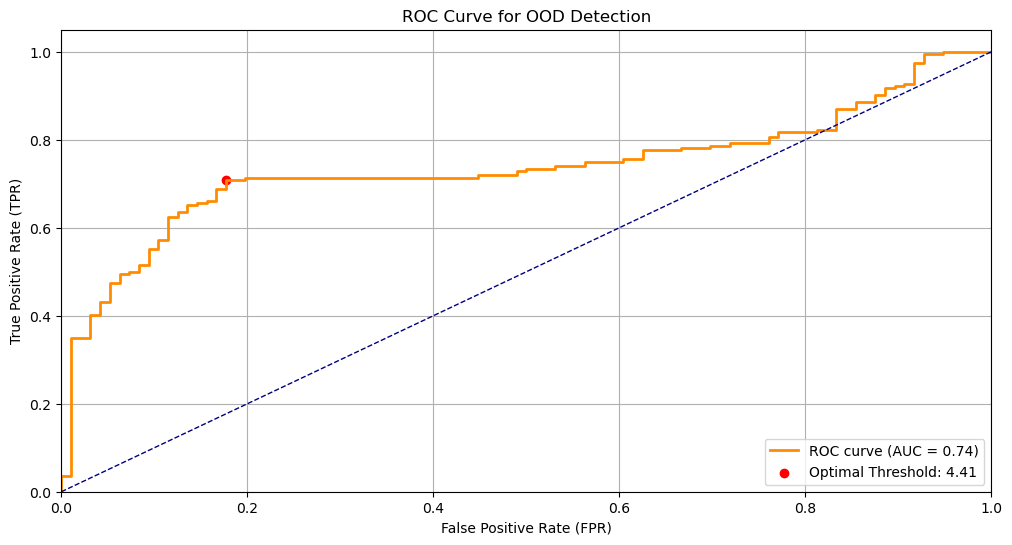

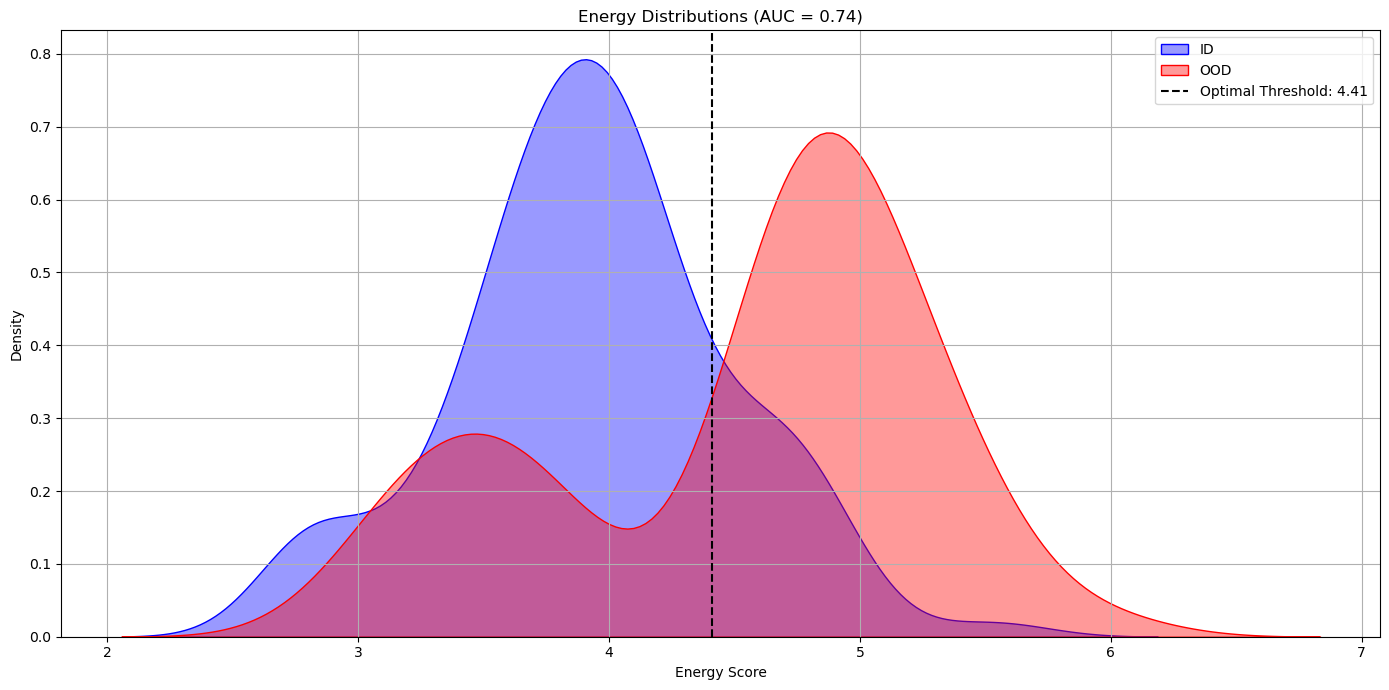

              precision    recall  f1-score   support

          ID       0.59      0.82      0.68        96
         OOD       0.89      0.71      0.79       192

    accuracy                           0.75       288
   macro avg       0.74      0.77      0.74       288
weighted avg       0.79      0.75      0.75       288

Optimal Threshold: 4.4100
AUC: 0.7367


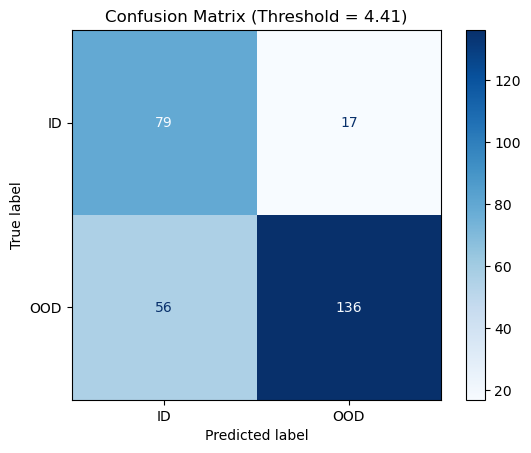

In [44]:
fpr, tpr, thresholds = roc_curve(is_ood, all_energy)
roc_auc = auc(fpr, tpr)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Plot ROC curve
plt.figure(figsize=(12, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red',
            label=f'Optimal Threshold: {optimal_threshold:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for OOD Detection')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("ROC_Casaurina.png", dpi=300)
plt.show()

# Plot KDE distributions
plt.figure(figsize=(14, 7))
sns.kdeplot(all_energy[~is_ood], label='ID', color='blue', fill=True, alpha=0.4)
sns.kdeplot(all_energy[is_ood], label='OOD', color='red', fill=True, alpha=0.4)
plt.axvline(optimal_threshold, color='black', linestyle='--', 
            label=f'Optimal Threshold: {optimal_threshold:.2f}')
plt.title(f"Energy Distributions (AUC = {roc_auc:.2f})")
plt.xlabel("Energy Score")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Energy_Distribution_Casuarina.png", dpi=300)
plt.show()

pred_ood = (all_energy >= optimal_threshold).astype(int)  # Higher energy = more likely OOD

# Print classification report
print(classification_report(is_ood, pred_ood, target_names=['ID', 'OOD']))
print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"AUC: {roc_auc:.4f}")

# Plot confusion matrix
cm = confusion_matrix(is_ood, pred_ood)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['ID', 'OOD'])
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix (Threshold = {optimal_threshold:.2f})")
plt.savefig("Classification_confusion_matrix_casuarina.png", dpi=300)
plt.grid(False)
plt.show()